In [8]:
using JuMP
import Ipopt
using StaticArrays, LinearAlgebra
using Plots
using Symbolics: Symbolics, @variables, scalarize
using Latexify
using BlockArrays: Block, BlockVector, mortar, blocksizes
using Ipopt
using SparseArrays
using CSV
using DataFrames
using Tables

In [9]:
function uni_dyna(x,u)
    return [x[1]+dt*u[1]*cos(x[3]), x[2]+dt*u[1]*sin(x[3]), x[3]+dt*u[2]]
end

function circleShape(h, k, r); gr()
    theta = LinRange(0, 2*pi, 500)
    h.+ r*sin.(theta), k.+ r*cos.(theta)
end

N = 100
n_x = 3
n_u = 2
state_dimension = 3
control_dimension = 2
horizon = N
tf = 10.
dt = tf/(N)
u1_b = 0.15
u2_b = 0.75

xo = @SVector [10.0,0.0]
ro = 4.0
ra = 3.0

# Q = 50.0*Diagonal(@SVector ones(6))
# Qf = 10000.0*Diagonal(@SVector ones(6))
# R = 1.0e0*Diagonal(@SVector ones(4))

Q = Diagonal(@SVector [50, 10, 5])*0.6 # This is reference tracking and control cost
Qf = Diagonal(@SVector [50, 10, 5])*50
R = Diagonal(@SVector [10, 5])*0.8

noise_level = 0.5

full_traj = []

num_sim = 1000

1000

In [10]:
for sim in 1:num_sim

    x0 = [0,0,0] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]
    xf = [20,0.0,0] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]

    # xf2 = @SVector [20,-2,0,0,-2,pi]

    X_ref = hcat(collect(LinRange(x0[1],xf[1],N+1)), 
            collect(LinRange(x0[2],xf[2],N+1)),
            collect(LinRange(x0[3],xf[3],N+1)),
            )

    problem_size = N*(n_x+n_u)

    model = Model(Ipopt.Optimizer)

    @variable(model, x11[1:N+1])
    @variable(model, x12[1:N+1])
    @variable(model, x13[1:N+1])

    @variable(model, 0<=u11[1:N+1] , start = 0)
    @variable(model, u12[1:N+1], start = 0);

    fix(x11[1],x0[1],force=true)
    fix(x12[1],x0[2],force=true)
    fix(x13[1],x0[3],force=true)

    fix(u11[N+1],0.0,force=true)
    fix(u12[N+1],0.0,force=true)

    X_full = vcat(x11',x12',x13')
    U_full = vcat(u11',u12')

    @objective(model, Min, tr((X_full'[1:N,:] - X_ref[1:N,:])*Q*(X_full[:,1:N] - X_ref'[:,1:N])) + tr(U_full'*R*U_full) + (X_full'[1+N,:] - X_ref[1+N,:])'*Qf*(X_full[:,1+N] - X_ref'[:,1+N]))

    @constraint(model, [t in 1:N], uni_dyna([x11[t],x12[t],x13[t]],[u11[t],u12[t]]) == [x11[t+1],x12[t+1],x13[t+1]]);
    @constraint(model, [t in 1:N+1], (xo[1] - x11[t])^2 + (xo[2] - x12[t])^2 - ro^2 >= 0);
    # @constraint(model, [t in 1:N+1], 
    #     x12[t] >= -0.5
    # )

    for i in 1:N+1
        set_start_value(x11[i],X_ref[i,1]+ 0.1*(2*rand()-1))
        set_start_value(x12[i],X_ref[i,2]+ 0.1*(2*rand()-1))
        set_start_value(x13[i],X_ref[i,3]+ 0.1*(2*rand()-1))

    end
    
    optimize!(model)

    @assert is_solved_and_feasible(model)

    X1 = hcat(value.(x11),value.(x12),value.(x13))

    traj = hcat(value.(u11),value.(u12),
                value.(x11),value.(x12),value.(x13), 
                )

    if sim == 1
        full_traj = traj[1:100,:]
        Plots.plot(circleShape(xo[1], xo[2], ro), seriestype = [:shape, ], lw=0.5, c = :gray, linecolor = :white, legend = false, fillalpha = 0.2, aspect_ratio = 1)
        Plots.plot!(X1[:,1],X1[:,2],color="blue",label="Agent 1")
        # Plots.plot!(X2[:,1],X2[:,2],color="orange",label="Agent 2")
    else
        full_traj = vcat(full_traj,traj[1:100,:])
        Plots.plot!(X1[:,1],X1[:,2],color = "blue",label="")
        # Plots.plot!(X2[:,1],X2[:,2],color="orange",label="")
    end
end

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     1095
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1296

Total number of variables............................:      500
                     variables with only lower bounds:      100
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:      101
        inequality constraints with only lower bounds:      101
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0379946e+01 1.60e+01 5.37e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

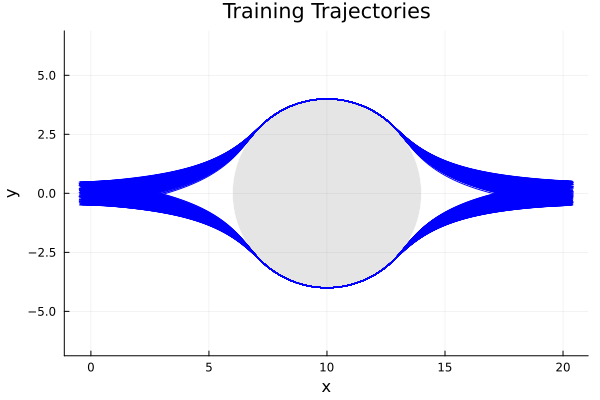

In [11]:
Plots.xlabel!("x")
Plots.ylabel!("y")
Plots.title!("Training Trajectories")

In [12]:
for i in 1:(size(full_traj)[2])
    println(maximum(full_traj[:,i]))
end

2.735450713694128
0.6770722193759872
20.24682929978644
3.999999894232202
0.9067920726748744


In [13]:
CSV.write("single_uni_full_traj.csv",  Tables.table(full_traj), writeheader=false)

"single_uni_full_traj.csv"

In [14]:
full_traj

100000×5 Matrix{Float64}:
 2.01423  -0.356477   -0.276224    0.0204589     0.0
 2.02317  -0.26916    -0.0748004   0.0204589    -0.0356477
 2.02815  -0.205731    0.127388    0.0132483    -0.0625637
 2.03106  -0.160396    0.329806    0.000567703  -0.0831369
 2.03292  -0.128743    0.53221    -0.0162984    -0.0991765
 2.03429  -0.107447    0.734503   -0.0364272    -0.112051
 2.03546  -0.0940141   0.936656   -0.0591739    -0.122796
 2.03659  -0.0865854   1.13867    -0.0841056    -0.132197
 2.03778  -0.0837805   1.34055    -0.11095      -0.140855
 2.03907  -0.0845802   1.54231    -0.139559     -0.149234
 ⋮                                              
 1.98862  -0.068232   18.3616     -0.529612      0.0985938
 1.9831   -0.0652545  18.5595     -0.510037      0.0917706
 1.97662  -0.0642919  18.757      -0.491864      0.0852452
 1.96895  -0.0658233  18.9539     -0.475035      0.078816
 1.9598   -0.0704866  19.1502     -0.459532      0.0722336
 1.94881  -0.0791188  19.3457     -0.445388      0.0